- Can we find heuristics (probably from the unaltered filtration) about which additional edges the adversaries are likely to add?
- which subgraphs actually touch the final layer?
- which subgraphs actually touch the final layer and contain the correct class as a node in the subgraph?

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.models.cff import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret

def draw_persistence_diagram(dgm, alpha=0.5, lims=None):
    ax = plt.subplot()
    
    births = []
    deaths = []
    for pt in dgm:
        if pt.death < float('inf'):
            births.append(pt.birth)
            deaths.append(pt.death)
    if lims is None:
        lims = [0.85*np.min(deaths), 1.15*np.max(births)]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.scatter(births, deaths, alpha=alpha, c='b')
    
    plt.xlabel('Birth Time')
    plt.ylabel('Death Time')

def draw_diagram_trajectory(dgms):
    alphas = np.geomspace(0.05, 0.75, num=len(dgms))
#     alphas = np.linspace(0.05, 0.75, num=len(dgms))
    i = 0
    max_birth = 0
    min_death = float('inf')
    for dgm in dgms:
        for pt in dgm:
            if pt.death < float('inf'):
                if pt.death < min_death:
                    min_death = pt.death
                if pt.birth > max_birth:
                    max_birth = pt.birth
    for dgm in dgms:
        draw_persistence_diagram(dgm, alpha=alphas[i], lims=[0.85*min_death, 1.15*max_birth])
        i += 1
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/projected_gradient_descent/cff_relu.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 0, 'pin_memory': False}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)
            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims


def move_to_adversary(model, ims, adv_ims, steps, labels, idxs, batch_size=10):
    device = torch.device("cpu")

    nims = []
    nlabs = []
    for j in range(len(ims)):
        cim = ims[j]
        diff_mat = (adv_ims[j] - ims[j])/steps
        for i in range(steps):
            cim = cim + diff_mat
            nims.append(cim.reshape(1,28,28))
            nlabs.append(labels[j])
    tims = torch.FloatTensor(nims)
    tlabels = torch.tensor(np.array(nlabs))
    dataset = torch.utils.data.TensorDataset(tims, tlabels)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    new_ims = np.empty((len(nims), 28*28))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'idx': idxs[(s+t)//steps], 'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                new_ims[s+t,:] = data[s].numpy().reshape(28*28)

            t += batch_size
            
    return pd.DataFrame(res_df), nms, wms, new_ims

def get_adv_dist(i,j):
    return np.linalg.norm(i-j,2)

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/cff_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms, ims = create_filtrations(model, 10, 100)

Filtration: 0
filtration size 52676
Filtration: 1
filtration size 69019
Filtration: 2
filtration size 35621
Filtration: 3
filtration size 76419
Filtration: 4
filtration size 63063
Filtration: 5
filtration size 38854
Filtration: 6
filtration size 63745
Filtration: 7
filtration size 54862
Filtration: 8
filtration size 75657
Filtration: 9
filtration size 66299
Filtration: 10
filtration size 81093
Filtration: 11
filtration size 77782
Filtration: 12
filtration size 56424
Filtration: 13
filtration size 74440
Filtration: 14
filtration size 39990
Filtration: 15
filtration size 77578
Filtration: 16
filtration size 65254
Filtration: 17
filtration size 57303
Filtration: 18
filtration size 85852
Filtration: 19
filtration size 54410
Filtration: 20
filtration size 59929
Filtration: 21
filtration size 58309
Filtration: 22
filtration size 67514
Filtration: 23
filtration size 66688
Filtration: 24
filtration size 57722
Filtration: 25
filtration size 96710
Filtration: 26
filtration size 48293
Filtration:

In [7]:
adv_df, adv_nms, adv_wms, adv_ims = create_adversary_filtrations(model, 10, 100, adversaries)

torch.Size([5000, 1, 28, 28])
Filtration: 0
filtration size 121587
Filtration: 1
filtration size 124729
Filtration: 2
filtration size 124118
Filtration: 3
filtration size 123692
Filtration: 4
filtration size 120303
Filtration: 5
filtration size 109502
Filtration: 6
filtration size 122306
Filtration: 7
filtration size 127587
Filtration: 8
filtration size 119820
Filtration: 9
filtration size 119719
Filtration: 10
filtration size 122049
Filtration: 11
filtration size 123128
Filtration: 12
filtration size 117366
Filtration: 13
filtration size 119375
Filtration: 14
filtration size 130875
Filtration: 15
filtration size 120521
Filtration: 16
filtration size 126838
Filtration: 17
filtration size 127145
Filtration: 18
filtration size 116147
Filtration: 19
filtration size 118994
Filtration: 20
filtration size 117572
Filtration: 21
filtration size 122158
Filtration: 22
filtration size 116308
Filtration: 23
filtration size 128684
Filtration: 24
filtration size 118896
Filtration: 25
filtration size

In [8]:
moves_df, moves_nms, moves_wms, moves_ims = move_to_adversary(model, ims, adv_ims, 20, res_df['prediction'], list(res_df.index), )

Filtration: 0
filtration size 117697
Filtration: 1
filtration size 118207
Filtration: 2
filtration size 118716
Filtration: 3
filtration size 119074
Filtration: 4
filtration size 119342
Filtration: 5
filtration size 119609
Filtration: 6
filtration size 119877
Filtration: 7
filtration size 119996
Filtration: 8
filtration size 120118
Filtration: 9
filtration size 120252
Filtration: 10
filtration size 120388
Filtration: 11
filtration size 120436
Filtration: 12
filtration size 120893
Filtration: 13
filtration size 120998
Filtration: 14
filtration size 121166
Filtration: 15
filtration size 121237
Filtration: 16
filtration size 121288
Filtration: 17
filtration size 121456
Filtration: 18
filtration size 121525
Filtration: 19
filtration size 121587
Filtration: 20
filtration size 119650
Filtration: 21
filtration size 120431
Filtration: 22
filtration size 121162
Filtration: 23
filtration size 121278
Filtration: 24
filtration size 121604
Filtration: 25
filtration size 121986
Filtration: 26
filtrat

filtration size 121440
Filtration: 214
filtration size 121529
Filtration: 215
filtration size 121588
Filtration: 216
filtration size 121710
Filtration: 217
filtration size 121846
Filtration: 218
filtration size 121955
Filtration: 219
filtration size 122049
Filtration: 220
filtration size 119034
Filtration: 221
filtration size 119677
Filtration: 222
filtration size 119953
Filtration: 223
filtration size 120404
Filtration: 224
filtration size 120766
Filtration: 225
filtration size 121180
Filtration: 226
filtration size 121322
Filtration: 227
filtration size 121517
Filtration: 228
filtration size 121549
Filtration: 229
filtration size 121745
Filtration: 230
filtration size 121968
Filtration: 231
filtration size 122130
Filtration: 232
filtration size 122291
Filtration: 233
filtration size 122595
Filtration: 234
filtration size 122586
Filtration: 235
filtration size 122625
Filtration: 236
filtration size 122762
Filtration: 237
filtration size 122902
Filtration: 238
filtration size 123192
Fi

KeyboardInterrupt: 

In [9]:
dists = np.array([get_adv_dist(ims[i], adv_ims[i]) for i in range(res_df.shape[0])])

In [10]:
adv_df.head()

,class,filtration,loss,prediction
0,7,"[(5175), (5192), (5175, 5192), (5190), (5175, ...",-10.362186,3
1,2,"[(5301), (5318), (5301, 5318), (5316), (5301, ...",-13.261440,3
2,1,"[(5264), (5297), (5264, 5297), (5251), (5291),...",-5.674807,8
3,0,"[(5255), (5272), (5255, 5272), (5270), (5255, ...",-0.700337,2
4,4,"[(5166), (5206), (5166, 5206), (5175), (5208),...",-6.562747,9


In [11]:
print('Adversary Accuracy:', adv_df[adv_df['prediction'] == adv_df['class']].shape[0]/adv_df.shape[0])
print('Actual Accuracy:', res_df[res_df['prediction'] == res_df['class']].shape[0]/res_df.shape[0])

Adversary Accuracy: 0.0
Actual Accuracy: 1.0


In [12]:
res_df.head()

,class,filtration,loss,prediction
0,7,"[(2430), (2447), (2430, 2447), (2439), (2445),...",-14.049807,7
1,2,"[(3123), (3140), (3123, 3140), (3138), (3123, ...",-15.757190,2
2,1,"[(1670), (1710), (1670, 1710), (1688), (1716),...",-9.077868,1
3,0,"[(3484), (3501), (3484, 3501), (3458), (3498),...",-0.000041,0
4,4,"[(2864), (2904), (2864, 2904), (2857), (2906),...",-10.368915,4


In [13]:
ids = [{v: k for k, v in nm.items()} for nm in nms]
adv_ids = [{v: k for k, v in nm.items()} for nm in adv_nms]
moves_ids = [{v: k for k, v in nm.items()} for nm in moves_nms]

NameError: name 'moves_nms' is not defined

In [14]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes


In [15]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
adv_sample_graphs, adv_dgms, adv_lifetimes = create_sample_graphs(adv_df, adv_ids, adv_wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
moves_sample_graphs, moves_dgms, moves_lifetimes = create_sample_graphs(moves_df, moves_ids, moves_wms)

In [17]:
adv_df.head(10)

,class,filtration,loss,prediction
0,7,"[(5175), (5192), (5175, 5192), (5190), (5175, ...",-10.362186,3
1,2,"[(5301), (5318), (5301, 5318), (5316), (5301, ...",-13.261440,3
2,1,"[(5264), (5297), (5264, 5297), (5251), (5291),...",-5.674807,8
3,0,"[(5255), (5272), (5255, 5272), (5270), (5255, ...",-0.700337,2
4,4,"[(5166), (5206), (5166, 5206), (5175), (5208),...",-6.562747,9
5,1,"[(4779), (4785), (4779, 4785), (4764), (4792),...",-9.826431,7
6,4,"[(5222), (5271), (5222, 5271), (5228), (5273),...",-15.146527,8
7,9,"[(5369), (5378), (5369, 5378), (5377), (5369, ...",-15.105375,3
8,5,"[(5218), (5226), (5218, 5226), (5222), (5218, ...",-14.257645,6
9,9,"[(5190), (5207), (5190, 5207), (5201), (5190, ...",-12.834895,4


In [ ]:
moves_df.head()

In [18]:
goi = 0

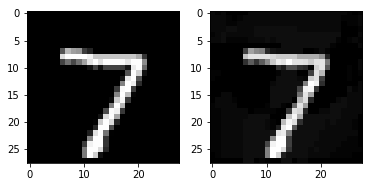

In [19]:
plt.subplot(121).imshow(ims[goi].reshape(28,28), cmap='gray')
plt.subplot(122).imshow(adv_ims[goi].reshape(28,28), cmap='gray')

In [ ]:
dion.plot.plot_diagram(dgms[goi])

In [ ]:
dion.plot.plot_diagram(adv_dgms[goi])

In [ ]:
movers = [moves_dgms[i] for i in list(moves_df[moves_df['idx'] == goi].index)]
for mover in movers:
    dion.plot.plot_diagram(mover, show=True)
    plt.close()

In [ ]:
for j in range(10):
    movers = [moves_dgms[i] for i in list(moves_df[moves_df['idx'] == j].index)]
    draw_diagram_trajectory(movers)
    plt.show()
    plt.close()

In [23]:
wassables = []
for dgm in dgms:
    ndgm = dion.Diagram()
    for pt in dgm:
        if pt.death < float('inf'):
            ndgm.append(pt)
    wassables.append(ndgm)
    
adv_wassables = []
for dgm in adv_dgms:
    ndgm = dion.Diagram()
    for pt in dgm:
        if pt.death < float('inf'):
            ndgm.append(pt)
    adv_wassables.append(ndgm)

wass_dists = [dion.wasserstein_distance(wassables[i], adv_wassables[i]) for i in range(len(dgms))]

In [24]:
wass_dists

[1.0607012510299683,
 1.2722461223602295,
 0.7836939692497253,
 1.5950158834457397,
 0.7758564949035645,
 0.6519790291786194,
 1.6704602241516113,
 0.3480086028575897,
 1.3997963666915894,
 0.7166141867637634,
 2.0438385009765625,
 0.6928786039352417,
 0.6478545069694519,
 0.5817508697509766,
 1.0436441898345947,
 0.8661063313484192,
 0.7501310110092163,
 0.6141365766525269,
 0.43397676944732666,
 1.4391831159591675,
 0.7851757407188416,
 0.23182493448257446,
 1.2390903234481812,
 1.0824576616287231,
 0.7209400534629822,
 0.8701276779174805,
 2.718677282333374,
 0.9632429480552673,
 0.9479994773864746,
 0.8864619731903076,
 0.7666870355606079,
 0.9630913138389587,
 0.6031328439712524,
 0.5653563737869263,
 1.1978503465652466,
 1.0073137283325195,
 0.6845306158065796,
 0.7937827706336975,
 1.0490642786026,
 0.8376671671867371,
 0.5431262850761414,
 0.6449331045150757,
 0.6080483198165894,
 0.649936854839325,
 0.772343099117279,
 0.9996116161346436,
 0.3198460042476654,
 1.12811219692230

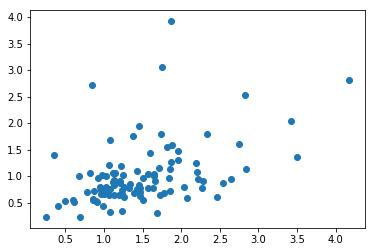

In [22]:
plt.scatter(dists, wass_dists)

In [ ]:
lifetimes[goi]

In [ ]:
adv_lifetimes[goi]

In [ ]:
sgk = (2,0,37)
agk = sgk
# agk = (2,0,46)

In [ ]:
mw = max([abs(edge[2]['weight']) for edge in sample_graphs[goi][sgk].edges(data=True)])
amw = max([abs(edge[2]['weight']) for edge in adv_sample_graphs[goi][agk].edges(data=True)])

widths = [abs(edge[2]['weight'])/mw + 0.1 for edge in sample_graphs[goi][sgk].edges(data=True)]
adv_widths = [abs(edge[2]['weight'])/amw + 0.1 for edge in adv_sample_graphs[goi][agk].edges(data=True)]

In [ ]:
# intersection = set(sample_graphs[goi][sgk].edges()).intersection(set(adv_sample_graphs[goi][agk].edges()))
# intersection

In [ ]:
difference = set(adv_sample_graphs[goi][agk].edges()).difference(set(sample_graphs[goi][sgk].edges()))
difference

In [ ]:
sorted_wm = sorted(np.absolute(np.array(list(wms[goi].values()))))

In [ ]:
percentiles = []
for k in difference:
    try:
        percentiles.append(sorted_wm.index(abs(wms[goi][k]))/len(sorted_wm))
        print(k, wms[goi][k], sorted_wm.index(abs(wms[goi][k]))/len(sorted_wm))
    except KeyError:
        try:
            percentiles.append(sorted_wm.index(abs(wms[goi][(k[1],k[0])]))/len(sorted_wm))
            print('rev', k, wms[goi][(k[1],k[0])], sorted_wm.index(abs(wms[goi][(k[1],k[0])]))/len(sorted_wm))
        except KeyError:
            percentiles.append(0)
            pass
#             print('cant do it', k)

In [ ]:
bins = 20
plt.hist(percentiles, bins, alpha=0.5, label='Difference', color='r')
# plt.hist(moved_dists, bins, alpha=0.5, label='Random Pertubation', color='b')
plt.xlabel('Percentile')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
def output_subgraph(gs):
    ret = {}
    for k in gs:
        ebunch = []
        for i in range(10): 
            ebunch += [e for e in gs[k].edges() if (3,0,i) in e]
        ret[k] = gs[k].edge_subgraph(ebunch)
    return ret

def output_class_subgraph(gs, cs):
    ret = {}
    for k in gs:
        ebunch = []
        for i in range(10): 
            ebunch += [e for e in gs[k].edges() if (e[0] in cs) or (e[1] in cs)]
        ret[k] = gs[k].edge_subgraph(ebunch)
    return ret

In [ ]:
tc = res_df.iloc[goi]['class']
ac = adv_df.iloc[goi]['prediction']
print('actual {}, adversarial {}'.format(tc, ac))

In [ ]:
# out_sgs = output_subgraph(sample_graphs[goi])
out_sgs = output_class_subgraph(sample_graphs[goi], [(3,0,tc),(3,0,ac)])

In [ ]:
# adv_out_sgs = output_subgraph(adv_sample_graphs[goi])
adv_out_sgs = output_class_subgraph(adv_sample_graphs[goi], [(3,0,tc),(3,0,ac)])

In [ ]:
out_sgs[sgk].edges(data=True)

In [ ]:
adv_out_sgs[agk].edges(data=True)

In [ ]:
lews = {(e[0],e[1]):e[2]['weight'] for e in out_sgs[sgk].edges(data=True)}
adv_lews = {(e[0],e[1]):e[2]['weight'] for e in adv_out_sgs[agk].edges(data=True)}

In [ ]:
mw = max([abs(edge[2]['weight']) for edge in out_sgs[sgk].edges(data=True)])
amw = max([abs(edge[2]['weight']) for edge in adv_out_sgs[agk].edges(data=True)])

widths = [abs(edge[2]['weight'])/mw + 0.1 for edge in out_sgs[sgk].edges(data=True)]
adv_widths = [abs(edge[2]['weight'])/amw + 0.1 for edge in adv_out_sgs[agk].edges(data=True)]

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 1,
    'width': widths,
    'with_labels':True}
pos = nx.circular_layout(out_sgs[sgk])
nx.draw(out_sgs[sgk], pos, **options)
nx.draw_networkx_edge_labels(out_sgs[sgk],pos,edge_labels=lews,font_color='blue')

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 1,
    'width': adv_widths,
    'with_labels':True}
pos = nx.circular_layout(adv_out_sgs[agk])
nx.draw(adv_out_sgs[agk], pos, **options)
nx.draw_networkx_edge_labels(adv_out_sgs[agk],pos,edge_labels=adv_lews,font_color='blue')

In [ ]:
all_out = nx.compose_all([out_sgs[k] for k in out_sgs])
adv_all_out = nx.compose_all([adv_out_sgs[k] for k in adv_out_sgs])
all_lews = {(e[0],e[1]):e[2]['weight'] for e in all_out.edges(data=True)}
all_adv_lews = {(e[0],e[1]):e[2]['weight'] for e in adv_all_out.edges(data=True)}
all_mw = max([abs(edge[2]['weight']) for edge in all_out.edges(data=True)])
all_amw = max([abs(edge[2]['weight']) for edge in adv_all_out.edges(data=True)])
all_widths = [abs(edge[2]['weight'])/mw + 0.1 for edge in all_out.edges(data=True)]
all_adv_widths = [abs(edge[2]['weight'])/amw + 0.1 for edge in adv_all_out.edges(data=True)]

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 1,
    'width': all_widths,
    'with_labels':True}
pos = nx.circular_layout(all_out)
nx.draw(all_out, pos, **options)
nx.draw_networkx_edge_labels(all_out,pos,edge_labels=all_lews,font_color='blue')

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 1,
    'width': all_adv_widths,
    'with_labels':True}
pos = nx.circular_layout(adv_all_out)
nx.draw(adv_all_out, pos, **options)
nx.draw_networkx_edge_labels(adv_all_out,pos,edge_labels=all_adv_lews,font_color='blue')

In [ ]:
noi = nms[goi][(3,0,ac)]
gf = []
for e in res_df.iloc[goi]['filtration']:
    if len(e) == 2:
        if e[0] == noi or e[1] == noi:
            gf.append(((ids[goi][e[0]],ids[goi][e[1]]), e.data))

In [ ]:
gf_sorted = sorted(gf, key=lambda x: abs(x[1]))

In [ ]:
gf_sorted

In [ ]:
model.params[2].weight.detach().numpy()[0].argsort()[::-1][:10]

In [ ]:
np.sort(model.params[2].weight.detach().numpy()[0])[::-1][:10]